Este cuadernillo contiene todo el c√≥digo empleado para realizar la parte de nuestro TFM relativa al an√°lisis del dataset Youtube Video Trending Dataset. Incluye las siguientes secciones:

- Instalaci√≥n de subprogramas y librer√≠as
- Preprocesamiento de los datos
- Obtenci√≥n y an√°lisis de caracter√≠sticas de los datos

## Instalaci√≥n de subprogramas y librer√≠as

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import isodate #para manejar formato de duraci√≥n ISO 8601
import re #para manejar expresiones regulares
from textblob import TextBlob
from lingua import Language, LanguageDetectorBuilder

## Preprocesamiento de datos

In [2]:
# PASO 1: LECTURA DEL ARCHIVO
df = pd.read_csv("youtube_trending_videos_global.csv", low_memory=False)

In [3]:
# El primer paso del preprocesado es eliminar columnas que consideramos innecesarias para el estudio. Estas son: 
# channel_id,video_dimension, channel_have_hidden_subscribers, channel_localized_title, channel_localized_description
elim_columns = ['channel_id','video_dimension', 'channel_have_hidden_subscribers', 'channel_localized_title', 'channel_localized_description']
df = df.drop(columns=elim_columns)

In [4]:
#Debemos eliminar las filas con video_id nulo, ya que esa ser√° la variable principal para la identificaci√≥n de los v√≠deos.
#Seg√∫n los metadatos ofrecidos por Kaggle, hay 13 instancias de ese tipo.
df = df.dropna(subset=['video_id'])

In [5]:
#A continuaci√≥n trataremos el resto de valores NaN.
#Para columnas alfanum√©ricas (string), cambiar por ""
#Para columnas num√©ricas,
alfanumeric_values = {"video_trending_country": "", "video_description": "", "video_category_id": "", "video_tags": ""}

#de momento no

In [6]:
#Guardamos el dataset resultante en un csv para evitar repetir el proceso
df.to_csv('ytvg_clean.csv', index=False)

In [7]:
#Creamos un dataset auxiliar que contenga solamente una instancia de cada v√≠deo. Es decir, deber√° tener unas 180.000 instancias.
df_unique = df.drop_duplicates(subset=['video_id'], keep='first')
df_unique.to_csv('ytvg_unique.csv', index=False)

## Obtenci√≥n y an√°lisis de caracter√≠sticas

In [17]:
df = pd.read_csv("ytvg_unique.csv")

In [18]:
df.columns

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'video_title', 'video_description',
       'video_default_thumbnail', 'video_category_id', 'video_tags',
       'video_duration', 'video_definition', 'video_licensed_content',
       'video_view_count', 'video_like_count', 'video_comment_count',
       'channel_title', 'channel_description', 'channel_custom_url',
       'channel_published_at', 'channel_country', 'channel_view_count',
       'channel_subscriber_count', 'channel_video_count'],
      dtype='object')

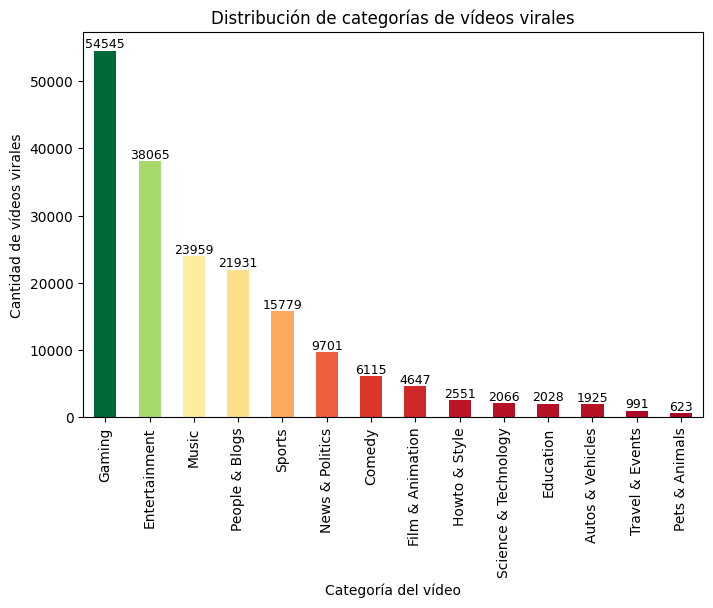

In [19]:
#An√°lisis de categor√≠as
categories = df['video_category_id'].value_counts()
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribuci√≥n de categor√≠as de v√≠deos virales")
plt.xlabel("Categor√≠a del v√≠deo")
plt.ylabel("Cantidad de v√≠deos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [20]:
#An√°lisis de duraci√≥n. Formato de la duraci√≥n: ISO 8601
#Transformar todas las duraciones a segundos.
df["video_duration_segs"] = df["video_duration"].apply(lambda x: int(isodate.parse_duration(x).total_seconds()))
df["video_duration_segs"].describe()

count    185223.000000
mean       2348.640957
std        5264.193158
min           0.000000
25%         174.000000
50%         758.000000
75%        1695.000000
max      158651.000000
Name: video_duration_segs, dtype: float64

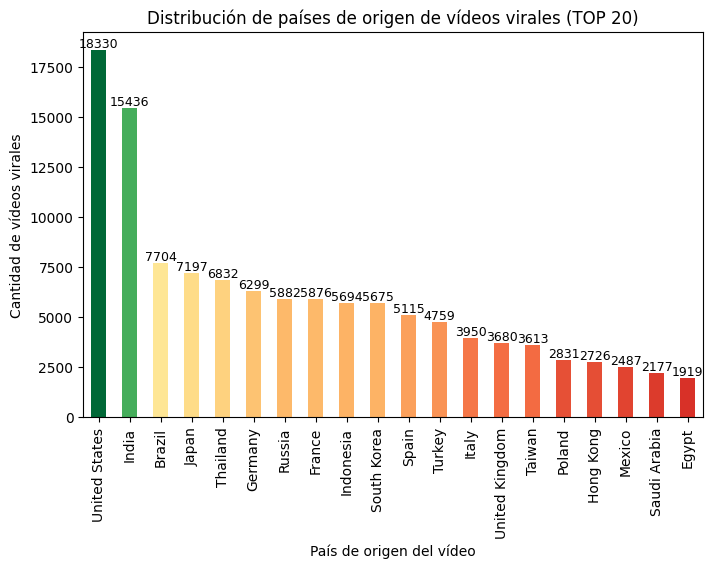

In [21]:
#Pa√≠s de origen de los v√≠deos
categories = df['channel_country'].value_counts()
categories = categories[0:20]
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribuci√≥n de pa√≠ses de origen de v√≠deos virales (TOP 20)")
plt.xlabel("Pa√≠s de origen del v√≠deo")
plt.ylabel("Cantidad de v√≠deos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [99]:
#Columnas para el idioma
languages = [Language.ENGLISH, Language.FRENCH, Language.GERMAN, Language.SPANISH, Language.ITALIAN, Language.PORTUGUESE, Language.ARABIC, Language.THAI, Language.HINDI, Language.CHINESE, Language.INDONESIAN, Language.RUSSIAN, Language.POLISH, Language.JAPANESE]
detector = LanguageDetectorBuilder.from_languages(*languages).with_preloaded_language_models().build()
#detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()
df['video_title_language'] = df['video_title'].apply(lambda x: str(detector.detect_language_of(str(x)))[9:])
df['vtl_confidence'] =  df['video_title'].apply(lambda x: detector.compute_language_confidence_values(str(x))[0].value)

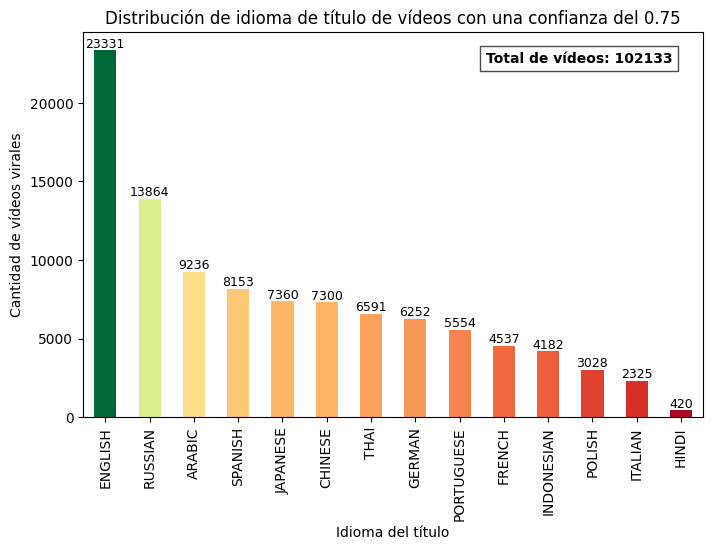

In [119]:
#Idioma de los t√≠tulos
confianza = 0.75
categories = df[df['vtl_confidence'] >= confianza]['video_title_language'].value_counts()
#categories = categories[0:20]
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribuci√≥n de idioma de t√≠tulo de v√≠deos con una confianza del {confianza}")
plt.xlabel("Idioma del t√≠tulo")
plt.ylabel("Cantidad de v√≠deos virales")
plt.xticks(rotation=90)

plt.text(0.95, 0.95, f"Total de v√≠deos: {categories.sum()}", 
         ha="right", va="top", transform=plt.gca().transAxes,
         fontsize=10, fontweight="bold", bbox=dict(facecolor="white", alpha=0.7))

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [116]:
#Tama√±o de los t√≠tulos: longitud y n√∫mero de palabras
df["video_title_len"] = df["video_title"].apply(lambda x: len(x))
df["video_title_words"]

14

In [120]:
len(df["video_title"][0])

38

In [100]:
#An√°lisis de t√≠tulo (idioma, tama√±o, emojis)
df

video_id    video_published_at video_trending__date  \
0       bB3-CUMERIU  2024-10-11T00:00:06Z           2024.10.12   
1       5ObJt_71AYc  2024-10-11T02:59:21Z           2024.10.12   
2       zfb0whgBBA8  2024-10-11T11:07:25Z           2024.10.12   
3       SJfoPdeOPCQ  2024-10-11T00:10:10Z           2024.10.12   
4       UVb6QOKy0bI  2024-10-09T12:30:27Z           2024.10.12   
...             ...                   ...                  ...   
185218  dM0DcZaQzPc  2025-08-11T17:27:23Z           2025.08.11   
185219  xFxpl6Ws3WI  2025-08-11T07:02:36Z           2025.08.11   
185220  QyGeGZRhCcI  2025-08-11T13:02:30Z           2025.08.11   
185221  OnKPYdSxlsY  2025-08-11T16:21:09Z           2025.08.11   
185222  M8Iz-ETyTGc  2025-08-11T01:39:01Z           2025.08.11   

       video_trending_country  \
0        United Arab Emirates   
1        United Arab Emirates   
2        United Arab Emirates   
3        United Arab Emirates   
4        United Arab Emirates   
...                       ...   
185218               Cambodia   
185219               Cambodia   
185220               Cambodia   
185221               Cambodia   
185222               Cambodia   

                                              video_title  \
0                  JENNIE - Mantra (Official Music Video)   
1       CHILE vs. BRASIL [1-2] | RESUMEN | ELIMINATORI...   
2                 ÿ™ÿ≠ÿØŸä ÿßŸÑÿ≠ŸÇŸäÿ®ÿ© ŸÖÿπ ÿßÿ®Ÿà ÿπÿ®Ÿäÿ± üî• | ÿ≥ŸÑÿ≥ŸÑÿ™ŸÜÿß #2   
3       VENEZUELA vs. ARGENTINA [1-1] | RESUMEN | ELIM...   
4       Bougainvillea Trailer | October 17 | Jyothirma...   
...                                                   ...   
185218                             ·ûí·üí·ûú·ûæBase......MazerSMP   
185219                                           ·ûî·û∂·ûâ·üãPUBG   
185220                                  KOLYOK ·ûò·ûÄ·û†·ûæ·ûô·ûò·ûÄ·û†·ûæ·ûô   
185221                    ·ûõ·üÅ·ûÑ 99 Nights in the Forest üå≥üî¶!   
185222  English SAKURA SchoolSimulator : üòç Excited str...   

                                        video_description  \
0       Official music video for ‚ÄúMantra‚Äù by JENNIE ou...   
1       #Chile #Brasil #eliminatoriassudamericanas #Cr...   
2       1,375,547 ŸÖÿ¥ÿ™ÿ±ŸÉ‚ù§Ô∏è\n\nŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄ...   
3       #Venezuela #Argentina #eliminatoriassudamerica...   
4       Presenting The Official Trailer of Bougainvill...   
...                                                   ...   
185218  Thank you for Watching\n---------------------M...   
185219  ---------------------------------\nSocial Medi...   
185220  ·ûî·ûæ·ûü·üí·ûö·û°·û∂·ûâ·üã·ûÖ·ûº·ûõ·ûÖ·û∑·ûè·üí·ûè ·ûü·ûº·ûò·ûÖ·ûª·ûÖ Subscribe ·ûì·û∑·ûÑ like vi...   
185221  ·ûü·ûò·üí·ûö·û∂·ûî·üã·ûÄ·û∂·ûö·ûõ·ûæ·ûÄ·ûë·ûπ·ûÄ·ûÖ·û∑·ûè·üí·ûè : https://drive.google.c...   
185222  Hey folks! Watch me play SAKURA SchoolSimulato...   

                                  video_default_thumbnail video_category_id  \
0          https://i.ytimg.com/vi/bB3-CUMERIU/default.jpg             Music   
1          https://i.ytimg.com/vi/5ObJt_71AYc/default.jpg            Sports   
2          https://i.ytimg.com/vi/zfb0whgBBA8/default.jpg            Gaming   
3          https://i.ytimg.com/vi/SJfoPdeOPCQ/default.jpg            Sports   
4          https://i.ytimg.com/vi/UVb6QOKy0bI/default.jpg  Film & Animation   
...                                                   ...               ...   
185218     https://i.ytimg.com/vi/dM0DcZaQzPc/default.jpg            Gaming   
185219  https://i.ytimg.com/vi/xFxpl6Ws3WI/default_liv...            Gaming   
185220  https://i.ytimg.com/vi/QyGeGZRhCcI/default_liv...            Gaming   
185221     https://i.ytimg.com/vi/OnKPYdSxlsY/default.jpg            Gaming   
185222     https://i.ytimg.com/vi/M8Iz-ETyTGc/default.jpg            Gaming   

                                               video_tags video_duration  ...  \
0       JENNIE,Mantra,Ï†úÎãà,Jennie Mantra,Jennie from Bla...        PT2M28S  ...   
1       f√∫tbol,pelota,gol,

## Preprocesamiento t√≠tulos - an√°lisis de sentimientos

In [9]:
#funcion para extraer algunas caracter√≠sticas del t√≠tulo
def extract_features(df):
    df['title_length'] = df['video_title'].apply(lambda x: len(str(x)))
    df['title_word_count'] = df['video_title'].apply(lambda x: len(str(x).split()))
    df['title_has_exclamation'] = df['video_title'].apply(lambda x: '!' in str(x))
    df['title_has_question'] = df['video_title'].apply(lambda x: '?' in str(x))
    df['title_sentiment'] = df['video_title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['description_length'] = df['video_description'].apply(lambda x: len(str(x)))
    df['description_sentiment'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df

In [13]:
df_preproc = df
df_preproc = extract_features(df_preproc)

# 2. Eliminar columnas irrelevantes
cols_to_drop = [
    'video_id', 'channel_id', 'video_title', 'video_description', 'video_default_thumbnail',
    'channel_title', 'channel_description', 'channel_custom_url', 'channel_localized_title',
    'channel_localized_description', 'thumbnail_url_hq', 'published_at'
]
cols_to_drop += ['video_tags', 'channel_country']  # Si tienen muchos nulos y no son cr√≠ticas
df_preproc.drop(columns=[col for col in cols_to_drop if col in df_preproc.columns], inplace=True)

# 3. Imputar valores nulos
num_cols = df_preproc.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    df_preproc[col].fillna(df_preproc[col].median(), inplace=True)
cat_cols = df_preproc.select_dtypes(include='object').columns
for col in cat_cols:
    df_preproc[col].fillna('Unknown', inplace=True)

# 4. Codificar variables categ√≥ricas
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    df_preproc[col] = LabelEncoder().fit_transform(df_preproc[col])

# 5. Estandarizar variables num√©ricas
from sklearn.preprocessing import StandardScaler
num_cols = df_preproc.select_dtypes(include=['float64', 'int64']).columns.drop(['viral_score'], errors='ignore')
scaler = StandardScaler()
df_preproc[num_cols] = scaler.fit_transform(df_preproc[num_cols])

C:\Users\belga\AppData\Local\Temp\ipykernel_8492\1140775893.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_preproc[col].fillna(df_preproc[col].median(), inplace=True)
C:\Users\belga\AppData\Local\Temp\ipykernel_8492\1140775893.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [14]:
df_preproc

video_published_at  video_trending__date  video_trending_country  \
0                -1.666140             -1.867158                1.493661   
1                -1.665602             -1.867158                1.493661   
2                -1.662870             -1.867158                1.493661   
3                -1.666040             -1.867158                1.493661   
4                -1.677745             -1.867158                1.493661   
...                    ...                   ...                     ...   
185218            1.688283              1.107798               -1.090263   
185219            1.665811              1.107798               -1.090263   
185220            1.680387              1.107798               -1.090263   
185221            1.687087              1.107798               -1.090263   
185222            1.660287              1.107798               -1.090263   

        video_category_id  video_duration  video_definition  \
0                0.341539        0.165476         -0.062773   
1                2.028219       -1.310178         -0.062773   
2               -0.333132        0.732882         -0.062773   
3                2.028219       -1.309979         -0.062773   
4               -0.670468        0.162097         -0.062773   
...                   ...             ...               ...   
185218          -0.333132        0.866237         -0.062773   
185219          -0.333132        2.054511         15.930385   
185220          -0.333132       -0.589741         15.930385   
185221          -0.333132        0.148384         -0.062773   
185222          -0.333132       -0.528131         15.930385   

        video_licensed_content  video_view_count  video_like_count  \
0                        False          6.482217         22.234123   
1                         True          1.044966         -0.225381   
2                         True          0.023463          0.831287   
3                         True          0.976928         -0.225381   
4                         True          0.311261          0.460445   
...                        ...               ...               ...   
185218                    True         -0.255682         -0.281592   
185219                    True         -0.255638         -0.283323   
185220                    True         -0.255893         -0.282265   
185221                    True         -0.256075         -0.282596   
185222                    True         -0.125791         -0.268758   

        video_comment_count  ...  channel_view_count  \
0                 37.686487  ...           -0.192032   
1                  0.377163  ...           -0.198288   
2                  2.359928  ...           -0.225451   
3                  0.517584  ...           -0.198288   
4                  0.456553  ...           -0.234451   
...                     ...  ...                 ...   
185218            -0.255228  ...           -0.236335   
185219            -0.255228  ...           -0.236026   
185220            -0.255228  ...           -0.236295   
185221            -0.255228  ...           -0.236077   
185222            -0.255228  ...           -0.227859   

        channel_subscriber_count  channel_video_count  title_length  \
0                       0.588224            -0.268870     -0.767424   
1                      -0.187478            -0.106227      0.643044   
2                      -0.205337            -0.259276     -0.725939   
3                      -0.187478            -0.106227      0.933435   
4                      -0.309339            -0.268410      1.638669   
...                          ...                  ...           ...   
185218                 -0.312127            -0.260621     -1.431173   
185219                 -0.310612            -0.259524     -2.011954   
185220                 -0.311756            -0.263701     -1.638595   
185221                 -0.310403            -0.264728     -1.057814   
185222                 -0.282442           

In [ ]:
# 6. Definir X e y para regresi√≥n
X = df_preproc.drop(['viral_score'], axis=1, errors='ignore')
y = df_preproc['viral_score']

# 7. Dividir en train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)